In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image, ImageOps
import os
import json
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import torch.optim as optim

import cv2

import random
import numpy as np
    
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [3]:
# Dataset do složky DataSet -- Dataset1
#                           |- Dataset2

# Rozdělit Dataset na 2-3 Train, Test, Validation
# Validation je až poslední
# shuffle data
# balance data nemít 40% stejnou ground truth (tohle je asi u classifierů)

#### DEFINE DataLoader ####


class data(Dataset):
    def __init__(self, path):
        self.len = 2000
        convert_tensor = transforms.ToTensor()
        convert_float = transforms.ConvertImageDtype(torch.float)
        src = cv2.imread('testingML.png', cv2.IMREAD_GRAYSCALE)
        self.Items = []

        for k in range(0,self.len):
            # generate random transform matrix
            translationX = random.uniform(30, 50) * random.choice([1, -1])
            translationY = random.uniform(30, 50) * random.choice([1, -1])
            translationMat = np.mat([[1., 0., translationX], [0., 1., translationY], [0., 0., 1.]] , dtype=np.float32)

            rotMat = cv2.getRotationMatrix2D( (src.shape[1]//2, src.shape[0]//2), random.uniform(-5, 5), 1 )
            transofrmMat = np.matmul(translationMat, np.vstack([rotMat, [0,0,1]]),  dtype=np.float32)
           
            # conver matrix to points
            points = [ [0, 0, 1], [1440, 1440, 1], [0, 1440, 1], ]
            warpedPoints = np.matmul(points, transofrmMat.transpose(),  dtype=np.float32)

            # image processing
            warped = cv2.warpAffine(src, transofrmMat[0:-1, : ], (1440, 1440))

            margin = 200
            img = src[margin:-margin, margin:-margin]
            warped = warped[margin:-margin, margin:-margin]

            img = cv2.resize(img, (128, 128))
            warped = cv2.resize(warped, (128, 128))

            # return values
            stacked = torch.stack((convert_tensor(img), convert_tensor(warped)))
            self.Items.append((stacked, torch.from_numpy(warpedPoints[:, 0:-1].flatten() ) ))

    # the function returns length of data
    def __len__(self):
        return self.len

    # gives one item at a time
    def __getitem__(self, index):
        return self.Items[index]


In [4]:
#### DEFINE Neural Network ####
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self._to_linear = None

        # 2 input image channel, 64 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv7 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.fc9 = nn.Linear(32768, 1024)

        self.fc10 = nn.Linear(1024, 6)

    def convs(self, x):
        # max pooling over 2x2
        # two conv layers
        x = self.conv1(x)
        x = self.conv2(x)

        # max pooling
        x = F.max_pool2d(x, 2)

        # two conv layers
        x = self.conv3(x)
        x = self.conv4(x)

        # max pooling
        x = F.max_pool2d(x, 2)

        # two conv layers
        x = self.conv5(x)
        x = self.conv6(x)

        # max pooling
        x = F.max_pool2d(x, 2)

        # two conv layers
        x = self.conv7(x)
        x = self.conv8(x)
            
        return x

    def forward(self, x):

        self.convs(x)
        x = x.view(-1, x[0].shape[0] * x[0].shape[1] * x[0].shape[2])

        # two linear layers
        x = self.fc9(x)
        x = self.fc10(x)
        
        return x


In [5]:
#### Create data ####

Dataset = data('testingML.png')
train_set, val_set = torch.utils.data.random_split(Dataset, [1800,200])
train_dataloader = DataLoader(train_set, batch_size=50, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=1, shuffle=True)

net = Net().to(device)

loss_function = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.1)

Epochs = 16
# Learning
for epoch in range(Epochs):
    for dataBatch in train_dataloader:
        images, groundTruths = dataBatch
        images, groundTruths = images.to(device), groundTruths.to(device)

        optimizer.zero_grad()

        outputs = net(images.view(-1, 2, 128, 128)) 

        loss = loss_function(outputs, groundTruths.view(-1,6))
        loss.backward() 
        optimizer.step() 
    # Training
    print(f"Epoch: {epoch}. Loss: {loss}")

Epoch: 0. Loss: 17273.431640625
Epoch: 1. Loss: 2245.190185546875
Epoch: 2. Loss: 1521.5701904296875
Epoch: 3. Loss: 1337.2640380859375
Epoch: 4. Loss: 882.6895751953125
Epoch: 5. Loss: 602.6707153320312
Epoch: 6. Loss: 465.6877136230469
Epoch: 7. Loss: 316.2936096191406
Epoch: 8. Loss: 255.79830932617188
Epoch: 9. Loss: 201.9717559814453
Epoch: 10. Loss: 116.59656524658203
Epoch: 11. Loss: 131.13470458984375
Epoch: 12. Loss: 124.53424835205078
Epoch: 13. Loss: 58.82640838623047
Epoch: 14. Loss: 70.53114318847656
Epoch: 15. Loss: 56.270835876464844


In [6]:
iterations = []
with torch.no_grad():
        for dataBatch in val_dataloader:
                images, groundTruths = dataBatch
                images, groundTruths = images.to(device), groundTruths.to(device)
                outputs = net(images.view(-1, 2, 128, 128)) 

                loss = loss_function(outputs, groundTruths.view(-1,6))
                iterations.append({ "batch": dataBatch, "outputs":outputs, "loss": loss})

In [7]:
iteration = random.choice(iterations)
im, gt = iteration["batch"]

np.set_printoptions(precision=3, suppress=True)

print(f"Ground Truth :\n {np.array(gt[0].view(3,2))}")
print(f"Transofrm    :\n {np.array(iteration['outputs'][0].view(3,2).cpu())}")
print(f"loss: {iteration['loss']}")

Ground Truth :
 [[  12.442   73.009]
 [1503.727 1459.828]
 [  64.675 1512.061]]
Transofrm    :
 [[  11.929   76.474]
 [1501.904 1458.467]
 [  69.412 1509.545]]
loss: 7.7035369873046875


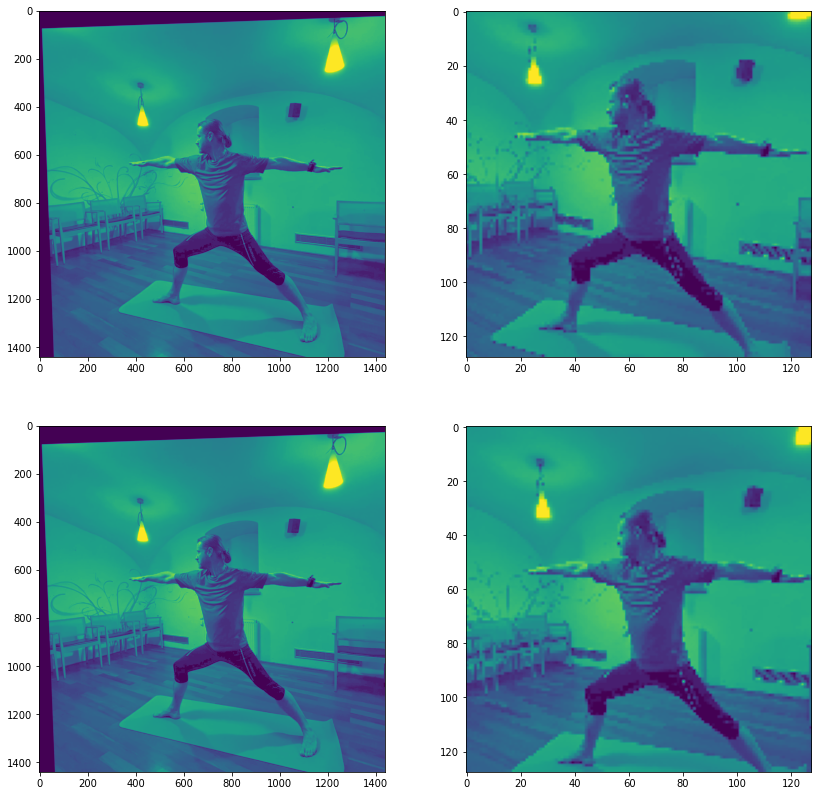

In [8]:
src = cv2.imread('testingML.png', cv2.IMREAD_GRAYSCALE)

groundPoints = np.array(gt.view(3,2))
# groundPoints = np.concatenate( (groundPoints, [[1], [1], [1],]), axis=1)

outputPoints = np.array(iteration['outputs'][0].view(3,2).cpu())
# outputPoints = np.concatenate( (outputPoints, [[1], [1], [1],]), axis=1)

srcPoints = np.array([ [0, 0], [1440, 1440], [0, 1440], ]).astype(np.float32)

fig, axes = plt.subplots(2, 2, figsize=(14, 14))

# Ground Truth
gtTransform = cv2.getAffineTransform(srcPoints, groundPoints)
warped = cv2.warpAffine(src, gtTransform, (1440, 1440))

axes[0][0].imshow(warped)

# Network Result
outputTransform = cv2.getAffineTransform(srcPoints, outputPoints)
warped = cv2.warpAffine(src, outputTransform, (1440, 1440))

axes[1][0].imshow(warped)

# Network Imputs
axes[0][1].imshow(im[0][0].view(128,128))

axes[1][1].imshow(im[0][1].view(128,128))